# Compute the total energy consumed in the scope of this study
We assume that all the job run between January 2022 and May 2022 are part of the study.

To get all the jobs for one user:    
`oarstat --sql "job_user='mjay'" -f -J | jq -C '.' | less -R`   
To save all the jobs into a yaml file:   
```
perso:~$ ssh lyon.g5k
mjay@flyon:~$ oarstat --sql "job_user='mjay'" -f -Y | less -R > grid5000_lyon_jobs.yaml
perso:~$ scp lyon.g5k:grid5000_lyon_jobs.yaml .
```

In [2]:
4*4*10

160

## Variables

In [1]:
user = 'mjay' #'vostapenco'
site = 'lyon'

repository_directory = "/home/mjay/GPU_benchmark_energy/"
yaml_file = "/home/mjay/GPU_benchmark_energy/grid5000_lyon_jobs_valdimir.yaml"

## Imports

In [2]:
import sys
sys.path.append(repository_directory + "code/")

import matplotlib.pyplot as plt
import time
from utils.tools import Wattmeter
import yaml
from yaml.loader import SafeLoader

## Get list of jobs into yaml file

From frontend terminal:
```
$ oarstat --sql "job_user='$user'" -f -Y | less -R > $yaml_file
```

## Parse file

In [4]:
def parse_yaml(file):
    # Open the file and load the file
    with open(file) as f:
        data = yaml.load(f, Loader=SafeLoader)
    jobs = {}
    for key, value in data.items():
        if len(value['assigned_network_address']) > 0:
            if "gemini" in value['assigned_network_address'][0]:
                jobs[key]={}
                jobs[key]['assigned_network_address'] = value['assigned_network_address'][0]
                jobs[key]['start_time'] = int(value['start_time'])
                jobs[key]['stop_time'] = int(value['stop_time'])
                jobs[key]['duration'] = int(value['stop_time']) - int(value['start_time'])
    return jobs

jobs = parse_yaml(yaml_file)

In [5]:
print(len(jobs.keys()))
list(jobs.keys())[0]

67


1287081

In [6]:
print("First job: ")
print(time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime(jobs[list(jobs.keys())[0]]["start_time"])))
print("Last job: ")
print(time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime(jobs[list(jobs.keys())[-1]]["start_time"])))
print(time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime(jobs[list(jobs.keys())[-1]]["stop_time"])))

First job: 
2022-01-24T10:02:10
Last job: 
2022-10-10T16:22:34
2022-10-10T16:25:35


## Let's study the duration of the jobs
And make sure their is no outlayer.

In [7]:
durations = [jobs[job]['duration'] for job in jobs.keys()]

(array([14.,  7.,  5.,  2.,  3.,  1.,  1.,  0.,  1.,  0.,  2.,  0.,  2.,
         0.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3., 18.]),
 array([2.800000e+01, 8.916200e+02, 1.755240e+03, 2.618860e+03,
        3.482480e+03, 4.346100e+03, 5.209720e+03, 6.073340e+03,
        6.936960e+03, 7.800580e+03, 8.664200e+03, 9.527820e+03,
        1.039144e+04, 1.125506e+04, 1.211868e+04, 1.298230e+04,
        1.384592e+04, 1.470954e+04, 1.557316e+04, 1.643678e+04,
        1.730040e+04, 1.816402e+04, 1.902764e+04, 1.989126e+04,
        2.075488e+04, 2.161850e+04, 2.248212e+04, 2.334574e+04,
        2.420936e+04, 2.507298e+04, 2.593660e+04, 2.680022e+04,
        2.766384e+04, 2.852746e+04, 2.939108e+04, 3.025470e+04,
        3.111832e+04, 3.198194e+04, 3.284556e+04, 3.370918e+04,
        3.457280e+04, 3.543642e+04, 3.630004e+04, 3.716366e+04,
        3.80

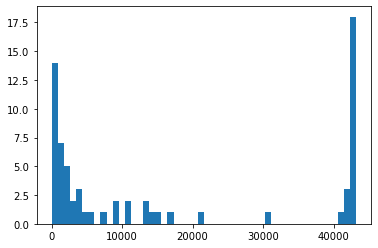

In [8]:
plt.hist(durations, bins=50)

In [9]:
max_key = max(jobs, key=lambda key: jobs[key]['duration'])
print(max_key)
jobs[max_key]

1314059


{'assigned_network_address': 'gemini-1.lyon.grid5000.fr',
 'start_time': 1649437200,
 'stop_time': 1649480409,
 'duration': 43209}

The longest job lasted for more than 48 hours for mjay.
For vostapenco, 12 hours.

# Get the corresponding power meter time series and compute the energy consumed
Let's use the methods already implemented as part of this study.

In [10]:
def retrieve_energy_per_jobs(jobs):
    for job in jobs.keys():
        if jobs[job]['duration'] > 2:
            try:
                wattmeter_data = Wattmeter(
                    jobs[job]['assigned_network_address'], 
                    'lyon', 
                    int(jobs[job]['start_time']), 
                    int(jobs[job]['stop_time']),
                    metrics=["wattmetre_power_watt"],
                )
                jobs[job]['energy_kWh'] = wattmeter_data.results["wattmetre_power_watt"]['energy_kWh']
                jobs[job]['energy_joule'] = wattmeter_data.results["wattmetre_power_watt"]['energy_joule']
            except:
                print(jobs[job]['start_time'])
                print(jobs[job]['stop_time'])
    return jobs

def compute_total_energy(jobs):
    total_energy_kWh = 0
    for job in jobs.keys():
        if 'energy_kWh' in jobs[job].keys():
            total_energy_kWh += jobs[job]['energy_kWh']
    return total_energy_kWh

jobs = retrieve_energy_per_jobs(jobs)
total_energy_consumed_kWh = compute_total_energy(jobs)

/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


1643014930
1643014958


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-war

1647614542
1647614823


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-war

1653990323
1653990664


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


1654096885
1654100032


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


1654100715
1654102513


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


1654102816
1654104996


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-war

1658484913
1658485184


/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mjay/.conda/envs/gpu_benchmark/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.grid5000.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-war

In [11]:
total_energy_consumed_kWh = compute_total_energy(jobs)
total_energy_consumed_kWh

346.41407095216385

# Results
All the jobs from `oarstat --sql "job_user='mjay'" -f -Y | less -R` lasting more than 2 seconds consumed 135.65 kWh.    
From `oarstat --sql "job_user='vostapenco'" -f -Y | less -R`, we get 346.41 kWh.